The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


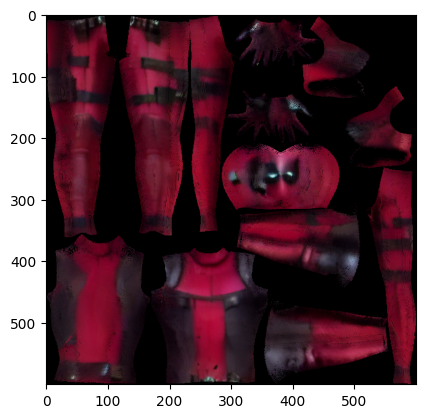

In [4]:
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
from text3d2video.artifacts.texture_artifact import TextureArtifact
import torch
import torchvision.transforms.functional as TF

torch.set_grad_enabled(False)

texture_art = TextureArtifact.from_wandb_artifact_tag("texture:v21")
texture = texture_art.read_texture()
plt.imshow(texture.cpu())

In [5]:
from text3d2video.artifacts.anim_artifact import AnimationArtifact
from text3d2video.rendering import render_depth_map, render_rgb_uv_map
from text3d2video.utilities.ipython_utils import display_vid
from text3d2video.utilities.video_util import pil_frames_to_clip


anim = AnimationArtifact.from_wandb_artifact_tag('catwalk_180_20:v0')
# anim = AnimationArtifact.from_wandb_artifact_tag('human_left_right:latest')
# anim = AnimationArtifact.from_wandb_artifact_tag('human_top_down:latest')
cams, meshes = anim.load_frames()
verts_uvs, faces_uvs = anim.uv_data()
depths = render_depth_map(meshes, cams)
uvs = render_rgb_uv_map(meshes, cams, verts_uvs, faces_uvs)
display_vid(pil_frames_to_clip(uvs))

In [6]:
from text3d2video.rendering import render_texture


renders = render_texture(meshes, cams, texture, verts_uvs, faces_uvs)
renders_pil = [TF.to_pil_image(r) for r in renders]

display_vid(pil_frames_to_clip(renders_pil))

In [179]:
from text3d2video.pipelines.generative_rendering_pipeline import (
    GenerativeRenderingPipeline
)
from text3d2video.pipelines.pipeline_utils import load_pipeline

device = torch.device("cuda")
dtype = torch.float16
sd_repo = "runwayml/stable-diffusion-v1-5"
controlnet_repo = "lllyasviel/control_v11f1p_sd15_depth"
pipe = load_pipeline(GenerativeRenderingPipeline, sd_repo, controlnet_repo)
pipe.scheduler.set_timesteps(10)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [182]:
from text3d2video.noise_initialization import UVNoiseInitializer
from PIL import Image

def noise_imgs(noises, res: int=512):
    images = []
    for noise in noises:
        noise_pil = TF.to_pil_image(noise[0:3, :, :].cpu())
        noise_pil = noise_pil.resize((res, res), Image.NEAREST)
        images.append(noise_pil)
    return images

uv_noise = UVNoiseInitializer(noise_texture_res=40)
noise = uv_noise.initial_noise(meshes, cams, verts_uvs, faces_uvs)

# noise = torch.randn_like(noise)

In [183]:
display_vid(pil_frames_to_clip(noise_imgs(noise)))

In [202]:
t = torch.Tensor([500]).long().cuda()

encoded = pipe.encode_images(renders)
encoded_noisy = pipe.scheduler.add_noise(encoded, noise, t).cuda()

In [205]:
prompt = "Deadpool"
cond_embeddings, uncond_embeddings = pipe.encode_prompt([prompt] * len(renders_pil))

noise_pred = pipe.model_forward_cfg(
    encoded_noisy,
    cond_embeddings,
    uncond_embeddings,
    t,
    depths,
    controlnet_conditioning_scale=0.3,
)

clean_image_pred = pipe.scheduler.step(
    noise_pred,
    t,
    encoded_noisy,
).pred_original_sample.to(dtype)

clean_image_pred_decoded = pipe.decode_latents(clean_image_pred)

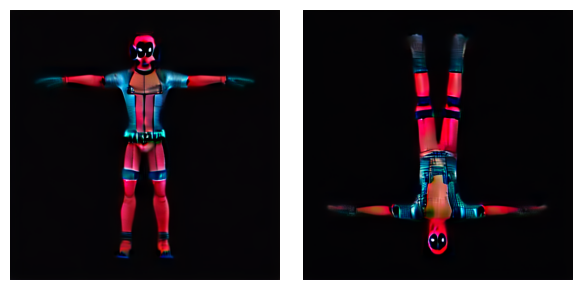

In [206]:
from text3d2video.utilities.ipython_utils import display_ims


display_ims(clean_image_pred_decoded)

In [186]:
# vid_noise_init = pil_frames_to_clip(clean_image_pred_decoded)
vid_rand_noise = pil_frames_to_clip(clean_image_pred_decoded)